In [199]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.options.display.max_columns = None

In [200]:
gl_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-Game-Log.csv')
gl_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Game-Log.csv')
gl_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Game-Log.csv')
gl_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Game-log.csv')
gl_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Game-Log.csv')

team_opp_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-PerGameTeamAndOpponentStats.csv')
team_opp_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Team&Opponent-Per-Game.csv')
team_opp_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Team&Opp-Per-Game.csv')
team_opp_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Team&Opponents.csv')
team_opp_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Team&Opp-Per-Game.csv')

roster_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-roster.csv')
roster_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Roster.csv')
roster_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Roster.csv')
roster_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Roster.csv')
roster_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Roster.csv')

In [201]:
# Adding a feature that tells us how much rest the Fighting Illini had before their current game

def add_rest_time(game_log):
    # Split the date into year, month, and day components
    date_parts = game_log['Date'].str.split('-', expand=True).astype(int)
    game_log['Year'], game_log['Month'], game_log['Day'] = date_parts[0], date_parts[1], date_parts[2]
    
    # Calculate rest days manually
    rest_days = []
    for i in range(len(game_log)):
        if i == 0:
            rest_days.append(0)  # First game has 0 rest days
        else:
            # Calculate difference between current and previous date
            prev_date = pd.Timestamp(game_log.loc[i-1, 'Year'], game_log.loc[i-1, 'Month'], game_log.loc[i-1, 'Day'])
            curr_date = pd.Timestamp(game_log.loc[i, 'Year'], game_log.loc[i, 'Month'], game_log.loc[i, 'Day'])
            rest_days.append((curr_date - prev_date).days)
        
    # Add the 'Rest Days' column to the DataFrame
    game_log['Rest Days'] = rest_days
    
    # Insert the 'Rest Days' column at index 8
    game_log.insert(8, 'Rest Days', game_log.pop('Rest Days'))
    
    # Drop the temporary Year, Month, and Day columns
    game_log.drop(columns=['Year', 'Month', 'Day'], inplace=True)
    
    return game_log

game_log_19_20 = add_rest_time(gl_19_20)
game_log_20_21 = add_rest_time(gl_20_21)
game_log_21_20 = add_rest_time(gl_20_21)
game_log_21_22 = add_rest_time(gl_21_22)
game_log_22_23 = add_rest_time(gl_22_23)
game_log_23_24 = add_rest_time(gl_23_24)

In [202]:
all_gl['Rest Days'].unique()

array([  0,   3,   2,   8,   6,   5,   4,   7,   1,  10,  13,  16,  -9,
       -82])

In [203]:
all_gl = pd.concat([gl_19_20, gl_20_21, gl_21_22, gl_22_23, gl_23_24], ignore_index=True)
all_gl = all_gl.drop(columns='Unnamed: 0')
all_gl

,Date,Time,Type,Opponent,Rank,Ranked Match,Conf,SRS,Rest Days,Result,PF,PA,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF.1,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
0,2019-11-05,8:00p,REG,Nicholls State,NaN,False,Southland,-3.87,0,W,78,70,1,0,True,1,0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29
1,2019-11-08,9:00p,REG,Grand Canyon,NaN,False,WAC,-6.32,3,W,83,71,2,0,False,2,0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23
2,2019-11-10,9:00p,REG,Arizona,21.0,True,Pac-12,19.49,2,L,69,90,2,1,False,0,1,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23
3,2019-11-18,8:00p,REG,Hawaii,NaN,False,Big West,-1.27,8,W,66,53,3,1,True,1,0,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18
4,2019-11-20,9:00p,REG,The Citadel,NaN,False,Southern,-13.82,2,W,85,57,4,1,True,2,0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2024-01-05,3:30p,CTOURN,Wisconsin,NaN,False,Big Ten,16.01,3,W,93,87,26,8,False,4,0,26,61,0.426,8,19,0.421,18,21,0.857,11,25,15,5,3,10,19,27,60,0.450,9,19,0.474,20,25,0.800,16,40,18,5,4,12,17
162,2024-01-11,3:10p,NCAA,Morehead State,NaN,False,OVC,0.51,6,W,85,69,27,8,False,5,0,23,55,0.418,7,21,0.333,18,22,0.818,7,31,11,3,6,7,10,29,69,0.420,5,19,0.263,5,7,0.714,12,34,10,4,4,7,15
163,2024-01-14,8:40p,NCAA,Duquesne,NaN,False,A-10,7.35,3,W,89,63,28,8,False,6,0,21,64,0.328,6,22,0.273,19,24,0.792,10,35,8,5,3,8,14,30,65,0.462,4,17,0.235,12,17,0.706,10,37,14,4,6,7,15
164,2024-01-18,10:09p,NCAA,Iowa State,4.0,True,Big 12,22.30,4,W,72,69,29,8,False,7,0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18


In [204]:
# Rename duplicate column names to be more concise
all_gl.rename(columns={'PF': 'Points For', 'PA' : 'Points Against', 'PF.1' : 'PF'}, inplace=True)
all_gl

,Date,Time,Type,Opponent,Rank,Ranked Match,Conf,SRS,Rest Days,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
0,2019-11-05,8:00p,REG,Nicholls State,NaN,False,Southland,-3.87,0,W,78,70,1,0,True,1,0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29
1,2019-11-08,9:00p,REG,Grand Canyon,NaN,False,WAC,-6.32,3,W,83,71,2,0,False,2,0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23
2,2019-11-10,9:00p,REG,Arizona,21.0,True,Pac-12,19.49,2,L,69,90,2,1,False,0,1,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23
3,2019-11-18,8:00p,REG,Hawaii,NaN,False,Big West,-1.27,8,W,66,53,3,1,True,1,0,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18
4,2019-11-20,9:00p,REG,The Citadel,NaN,False,Southern,-13.82,2,W,85,57,4,1,True,2,0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2024-01-05,3:30p,CTOURN,Wisconsin,NaN,False,Big Ten,16.01,3,W,93,87,26,8,False,4,0,26,61,0.426,8,19,0.421,18,21,0.857,11,25,15,5,3,10,19,27,60,0.450,9,19,0.474,20,25,0.800,16,40,18,5,4,12,17
162,2024-01-11,3:10p,NCAA,Morehead State,NaN,False,OVC,0.51,6,W,85,69,27,8,False,5,0,23,55,0.418,7,21,0.333,18,22,0.818,7,31,11,3,6,7,10,29,69,0.420,5,19,0.263,5,7,0.714,12,34,10,4,4,7,15
163,2024-01-14,8:40p,NCAA,Duquesne,NaN,False,A-10,7.35,3,W,89,63,28,8,False,6,0,21,64,0.328,6,22,0.273,19,24,0.792,10,35,8,5,3,8,14,30,65,0.462,4,17,0.235,12,17,0.706,10,37,14,4,6,7,15
164,2024-01-18,10:09p,NCAA,Iowa State,4.0,True,Big 12,22.30,4,W,72,69,29,8,False,7,0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18


In [205]:
all_gl.isna().sum()

Date                0
Time                0
Type                0
Opponent            0
Rank              120
Ranked Match        0
Conf                1
SRS                 1
Rest Days           0
Result              0
Points For          0
Points Against      0
W                   0
L                   0
Home Game           0
Win Streak          0
Lose Streak         0
FG                  0
FGA                 0
FG%                 0
3P                  0
3PA                 0
3P%                 0
FT                  0
FTA                 0
FT%                 0
ORB                 0
TRB                 0
AST                 0
STL                 0
BLK                 0
TOV                 0
PF                  0
OPP FG              0
OPP FGA             0
OPP FG%             0
OPP 3P              0
OPP 3PA             0
OPP 3P%             0
OPP FT              0
OPP FTA             0
OPP FT%             0
OPP ORB             0
OPP TRB             0
OPP AST             0
OPP STL   

In [206]:
# Find the row with missing values
lindenwood = all_gl.loc[all_gl['Conf'].isna()]
lindenwood

,Date,Time,Type,Opponent,Rank,Ranked Match,Conf,SRS,Rest Days,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
6,2019-11-26,8:00p,REG,Lindenwood,NaN,False,NaN,NaN,3,W,117,65,6,1,True,4,0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30


In [207]:
# Fill in missing conference value
lindenwood['Conf'] = 'OVC'
lindenwood

,Date,Time,Type,Opponent,Rank,Ranked Match,Conf,SRS,Rest Days,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
6,2019-11-26,8:00p,REG,Lindenwood,NaN,False,OVC,NaN,3,W,117,65,6,1,True,4,0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30


In [208]:
# Fill in missing SRS value with an estimate
lindenwood['SRS'] = 42
lindenwood

,Date,Time,Type,Opponent,Rank,Ranked Match,Conf,SRS,Rest Days,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
6,2019-11-26,8:00p,REG,Lindenwood,NaN,False,OVC,42,3,W,117,65,6,1,True,4,0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30


In [209]:
all_gl.loc[all_gl['Conf'].isna()] = lindenwood

In [210]:
all_gl.isna().sum()

Date                0
Time                0
Type                0
Opponent            0
Rank              120
Ranked Match        0
Conf                0
SRS                 0
Rest Days           0
Result              0
Points For          0
Points Against      0
W                   0
L                   0
Home Game           0
Win Streak          0
Lose Streak         0
FG                  0
FGA                 0
FG%                 0
3P                  0
3PA                 0
3P%                 0
FT                  0
FTA                 0
FT%                 0
ORB                 0
TRB                 0
AST                 0
STL                 0
BLK                 0
TOV                 0
PF                  0
OPP FG              0
OPP FGA             0
OPP FG%             0
OPP 3P              0
OPP 3PA             0
OPP 3P%             0
OPP FT              0
OPP FTA             0
OPP FT%             0
OPP ORB             0
OPP TRB             0
OPP AST             0
OPP STL   

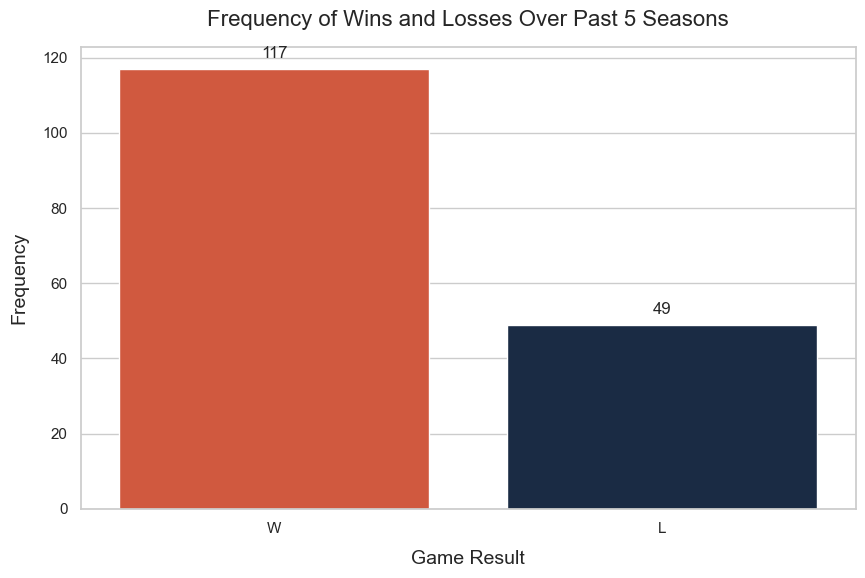

In [211]:
# Calculate the result counts
result_counts = all_gl['Result'].value_counts().reset_index()
result_counts.columns = ['Result', 'Frequency']

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.barplot(data=result_counts, x='Result', y='Frequency', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.title('Frequency of Wins and Losses Over Past 5 Seasons', fontsize=16, pad=15)

# Adding value annotations on top of the bars
for index, row in result_counts.iterrows():
    plt.text(row.name, row.Frequency + 2, row.Frequency, ha='center', va='bottom', fontsize=12)

plt.show()


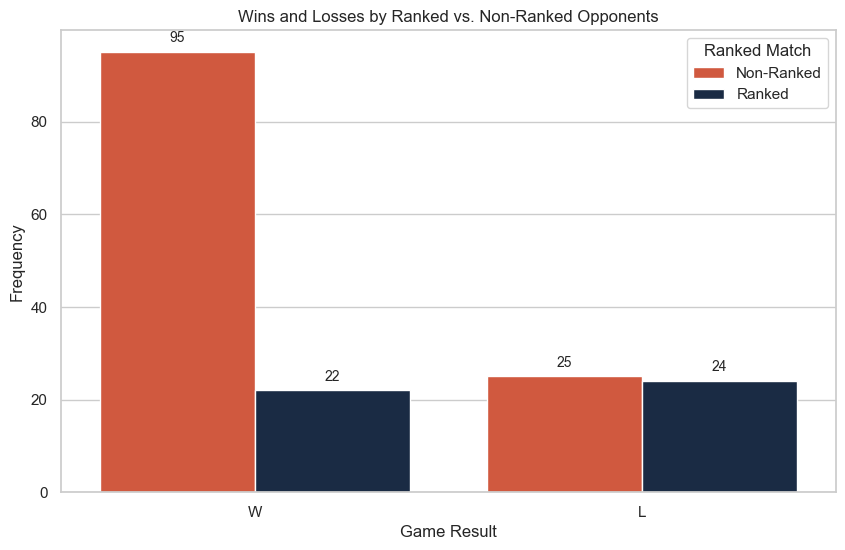

In [212]:
# Observe how well we do against ranked teams
plt.figure(figsize=(10, 6))

# Create a grouped bar plot using 'Result' and 'Ranked Match' columns
plot = sns.countplot(data=all_gl, x='Result', hue='Ranked Match', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result')
plt.ylabel('Frequency')
plt.title('Wins and Losses by Ranked vs. Non-Ranked Opponents')
plt.legend(title='Ranked Match', labels=['Non-Ranked', 'Ranked'])

# Adds count at the top of the bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.show()

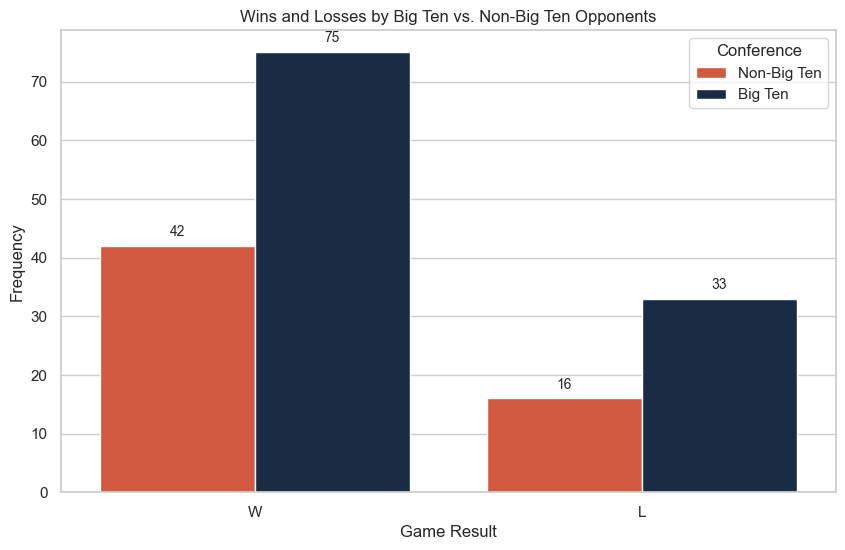

In [213]:
# What about for Conference vs. Non-Conference games
conf_gl = all_gl.copy()

conf_gl['Big_Ten_Opponent'] = conf_gl['Conf'].apply(lambda x: 'Big Ten' if x == 'Big Ten' else 'Non-Big Ten')

plt.figure(figsize=(10, 6))

# Create a grouped bar plot for Wins/Losses against Big Ten vs. Non-Big Ten teams
plot = sns.countplot(data=conf_gl, x='Result', hue='Big_Ten_Opponent', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result')
plt.ylabel('Frequency')
plt.title('Wins and Losses by Big Ten vs. Non-Big Ten Opponents')
plt.legend(title='Conference', labels=['Non-Big Ten', 'Big Ten'])

# Add counts at the top of each bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.show()

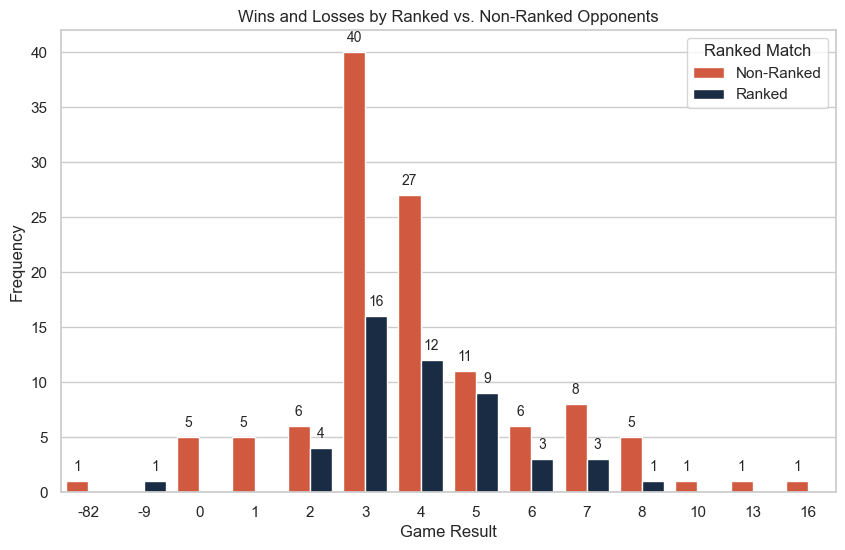

In [214]:
# Observe how the relationship between rest days and game results
plt.figure(figsize=(10, 6))

plot = sns.countplot(data=all_gl, x='Rest Days', hue='Result', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result')
plt.ylabel('Frequency')
plt.title('Wins and Losses by Ranked vs. Non-Ranked Opponents')
plt.legend(title='Ranked Match', labels=['Non-Ranked', 'Ranked'])

# Adds count at the top of the bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.show()

In [215]:
# Make a numeric only game log data frame for our correlation matrix
num_gl = all_gl.copy()
num_gl['Result'] = num_gl['Result'].apply(lambda x: 1 if x == 'W' else 0)
num_gl['Ranked Match'] = num_gl['Ranked Match'].apply(lambda x: 1 if x == True else 0)
num_gl['Home Game'] = num_gl['Home Game'].apply(lambda x: 1 if x == True else 0)
num_gl['Type'] = num_gl['Type'].astype('category').cat.codes
num_gl['Conf'] = num_gl['Conf'].astype('category').cat.codes
num_gl = num_gl.drop(columns=['Date','Time','Rank','Opponent'])
num_gl

,Type,Ranked Match,Conf,SRS,Rest Days,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
0,2,0,21,-3.87,0,1,78,70,1,0,1,1,0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29
1,2,0,24,-6.32,3,1,83,71,2,0,0,2,0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23
2,2,1,16,19.49,2,0,69,90,2,1,0,0,1,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23
3,2,0,7,-1.27,8,1,66,53,3,1,1,1,0,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18
4,2,0,20,-13.82,2,1,85,57,4,1,1,2,0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0,0,6,16.01,3,1,93,87,26,8,0,4,0,26,61,0.426,8,19,0.421,18,21,0.857,11,25,15,5,3,10,19,27,60,0.450,9,19,0.474,20,25,0.800,16,40,18,5,4,12,17
162,1,0,15,0.51,6,1,85,69,27,8,0,5,0,23,55,0.418,7,21,0.333,18,22,0.818,7,31,11,3,6,7,10,29,69,0.420,5,19,0.263,5,7,0.714,12,34,10,4,4,7,15
163,1,0,0,7.35,3,1,89,63,28,8,0,6,0,21,64,0.328,6,22,0.273,19,24,0.792,10,35,8,5,3,8,14,30,65,0.462,4,17,0.235,12,17,0.706,10,37,14,4,6,7,15
164,1,1,3,22.30,4,1,72,69,29,8,0,7,0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18


In [216]:
# Create correlation matrix
gl_corr = num_gl.corr()
gl_corr

,Type,Ranked Match,Conf,SRS,Rest Days,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
Type,1.000000,-0.030473,0.063755,-0.143599,-0.025714,0.017303,-0.013791,-0.122046,-0.505196,-0.378055,0.314180,-0.234227,-0.046887,-0.026278,-0.019801,-0.004968,0.075497,0.107015,0.012197,-0.132161,-0.122136,-0.040119,0.003853,0.057074,-0.104227,-0.033579,0.009428,0.121214,0.009221,-0.102009,-0.039764,-0.081075,-0.019613,0.035311,-0.023185,-0.041117,-0.014437,-0.143995,-0.013960,-0.053442,-0.104331,0.049641,-0.015048,0.076969,-0.045986
Ranked Match,-0.030473,1.000000,-0.210393,0.494297,0.050372,-0.307529,-0.215956,0.256143,0.132115,0.140660,-0.154066,-0.174352,0.208216,-0.111847,-0.098878,-0.053695,-0.024221,-0.063622,0.058443,-0.095936,-0.133440,0.053505,-0.237245,-0.276419,-0.129529,-0.016590,-0.139170,0.003965,0.231487,0.236536,0.003568,0.230974,0.195680,0.196681,0.061795,0.222718,0.209847,0.073223,0.191592,0.209267,0.336671,0.008429,0.036074,-0.071495,-0.143821
Conf,0.063755,-0.210393,1.000000,-0.544133,0.024315,0.116823,0.213062,-0.204840,-0.384889,-0.365990,0.168556,-0.091879,-0.097394,0.181597,0.059481,0.162790,0.034688,0.076679,-0.087367,0.170722,0.232898,-0.052210,0.214734,0.232544,0.095488,0.204666,0.063254,0.340438,-0.063584,-0.156109,0.103235,-0.210905,-0.053509,0.077512,-0.112558,-0.098696,-0.095279,-0.075984,0.006091,-0.180549,-0.124995,0.265853,-0.122097,0.350028,0.298049
SRS,-0.143599,0.494297,-0.544133,1.000000,-0.018778,-0.368844,-0.360192,0.430328,0.402195,0.415786,-0.333310,-0.041001,0.318224,-0.368120,-0.192892,-0.284552,-0.147101,-0.126318,-0.030999,-0.004202,-0.077079,0.111942,-0.320031,-0.414009,-0.283359,-0.144274,-0.176202,-0.171348,0.190419,0.334399,-0.024953,0.340709,0.161204,0.005666,0.155047,0.228819,0.203914,0.122284,0.176437,0.321177,0.257056,-0.068390,0.130059,-0.240649,-0.095286
Rest Days,-0.025714,0.050372,0.024315,-0.018778,1.000000,-0.031800,-0.089243,-0.079814,-0.015094,0.016465,0.093090,-0.005329,0.045636,-0.048548,0.001577,-0.060215,-0.034684,-0.092209,0.040906,0.029198,-0.042782,0.120903,0.023295,-0.098379,-0.037520,0.036580,-0.017497,-0.039689,0.045573,0.076666,-0.106468,0.122051,0.063266,0.094821,-0.014912,0.016198,-0.019479,0.070149,-0.049239,-0.045106,0.057440,0.040845,0.046222,0.056162,-0.098847
Result,0.017303,-0.307529,0.116823,-0.368844,-0.031800,1.000000,0.404264,-0.488643,-0.028972,-0.205387,0.295989,0.638788,-0.860560,0.353430,-0.015423,0.420372,0.053406,-0.115719,0.186786,0.235833,0.258117,-0.006880,0.037808,0.360312,0.297493,-0.066848,0.114587,-0.046704,-0.241891,-0.317650,0.234166,-0.471648,-0.132209,0.079264,-0.231392,-0.386908,-0.357548,-0.145007,-0.114162,-0.255935,-0.219161,-0.139569,-0.156929,0.043027,0.188236
Points For,-0.013791,-0.215956,0.213062,-0.360192,-0.089243,0.404264,1.000000,0.202072,-0.151105,-0.294883,0.169752,0.262566,-0.390061,0.830228,0.434484,0.681334,0.461415,0.140516,0.473274,0.388018,0.346005,0.161610,0.227877,0.318563,0.550373,0.132113,0.025269,0.035976,0.028807,0.110229,0.328427,-0.077243,0.152006,0.145008,0.093108,0.017859,0.033525,0.012343,-0.055958,-0.345906,0.086074,-0.040553,-0.104430,0.204789,0.250010
Points Against,-0.122046,0.256143,-0.204840,0.430328,-0.079814,-0.488643,0.202072,1.000000,0.221999,0.238702,-0.300862,-0.262042,0.374705,0.078536,0.157368,0.008687,0.114539,0.054451,0.138369,0.143474,0.078997,0.147280,-0.050866,-0.328654,-0.097995,-0.094741,-0.195698,-0.032760,0.296497,0.727843,0.155699,0.647155,0.364277,0.052548,0.417564,0.466314,0.423270,0.240170,0.152394,0.150290,0.472035,0.073217,0.146762,-0.186455,0.051843
W,-0.505196,0.132115,-0.384889,0.402195,-0.015094,-0.028972,-0.151105,0.221999,1.000000,0.893165,-0.291919,0.198150,0.053830,-0.165884,-0.066474,-0.155102,-0.161981,-0.083270,-0.107362,0.046380,-0.002707,0.096966,-0.149512,-0.22581

In [217]:
# The variables that have the most affect on the Result column in order
result_corr = gl_corr['Result'].drop('Result')
result_corr = result_corr.abs().sort_values(ascending=False)
result_corr = result_corr.reset_index()
result_corr.columns = ['Variable', 'Correlation with Result']
result_corr


,Variable,Correlation with Result
0,Lose Streak,0.860560
1,Win Streak,0.638788
2,Points Against,0.488643
3,OPP FG%,0.471648
4,FG%,0.420372
5,Points For,0.404264
6,OPP FT,0.386908
7,SRS,0.368844
8,TRB,0.360312
9,OPP FTA,0.357548


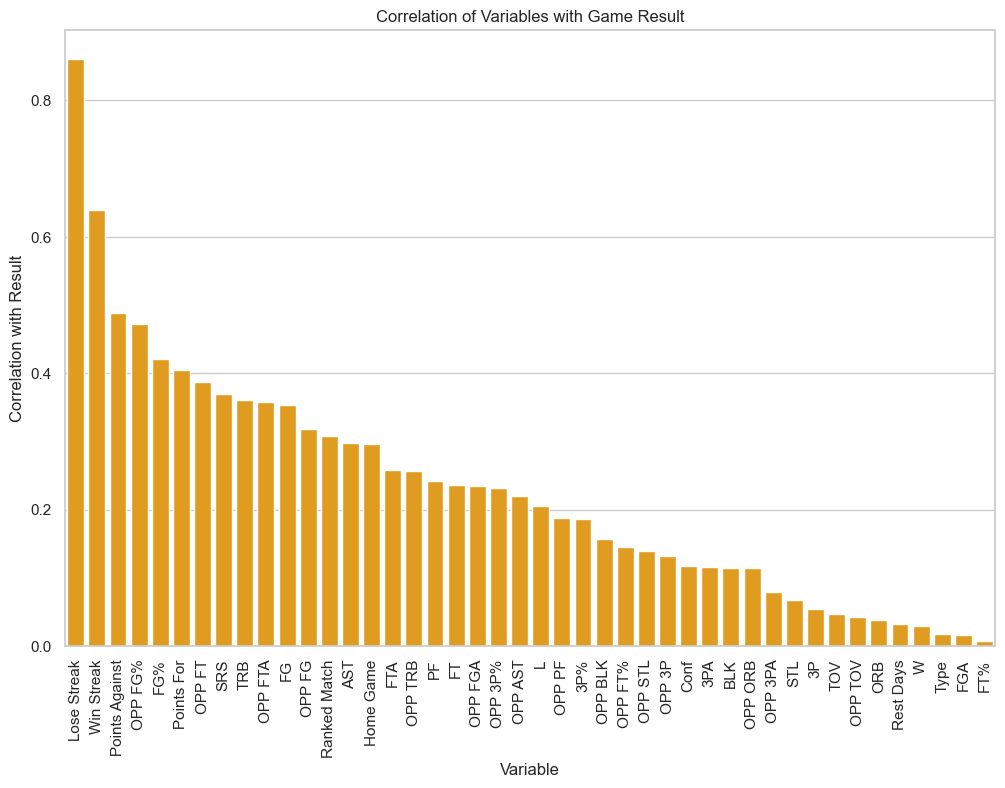

In [218]:
# Visualization to easily view what variables had the highest correlation with result
plt.figure(figsize=(12, 8))
sns.barplot(data=result_corr, x='Variable', y='Correlation with Result', color='orange')
plt.xticks(rotation=90)
plt.title('Correlation of Variables with Game Result')
plt.xlabel('Variable')
plt.ylabel('Correlation with Result')
plt.show()

In [219]:
import warnings
warnings.filterwarnings('ignore') #mutes warnings for 2021 and 2122 

s1920 = ['19-20', '19-20', '19-20', '19-20', '19-20', '19-20', '19-20', 
         '19-20', '19-20', '19-20' , '19-20', '19-20', '19-20', '19-20']
roster_19_20['Season'] = s1920 # add season columns to rosters for analysis later

s2021 = ['20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21'
         '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21']
roster_20_21['Season'] = s2021
roster_20_21['Season'][6] = '20-21'

s2122 = ['21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22'
         '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22']
roster_21_22['Season'] = s2122
roster_21_22['Season'][6] = '21-22'


s2223 = ['22-23', '22-23', '22-23', '22-23', '22-23',
         '22-23', '22-23', '22-23', '22-23', '22-23', 
         '22-23', '22-23', '22-23', '22-23', '22-23']
roster_22_23['Season'] = s2223

s2324 = ['23-24', '23-24', '23-24', '23-24', '23-24', '23-24',
         '23-24', '23-24', '23-24', '23-24', '23-24', '23-24'
         ,'23-24']
roster_23_24['Season'] = s2324


all_rosters = pd.concat([roster_19_20, roster_20_21, roster_21_22, roster_22_23, roster_23_24], ignore_index= True)
count_players = all_rosters['Player'].value_counts()
multiple_season = count_players[count_players > 1].index.to_list()
attributes = ['Player', 'Season', 'PTS', 'REB', 'AST']
roster_performance = all_rosters[all_rosters['Player'].isin(multiple_season)][attributes]
player_pts = roster_performance.pivot(index = 'Season', columns = 'Player', values = 'PTS')
plt.figure(figsize = (10,8))
player_pts
for player in player_pts.columns :
    plt.plot(player_pts.index, player_pts[player], marker = 'o', label = player)

plt.title('Points Per Game Trends for Players Across Seasons')
plt.xlabel('Season')
plt.ylabel('Points Per Game')
plt.xticks(rotation=45)
plt.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

KeyError: "['REB'] not in index"

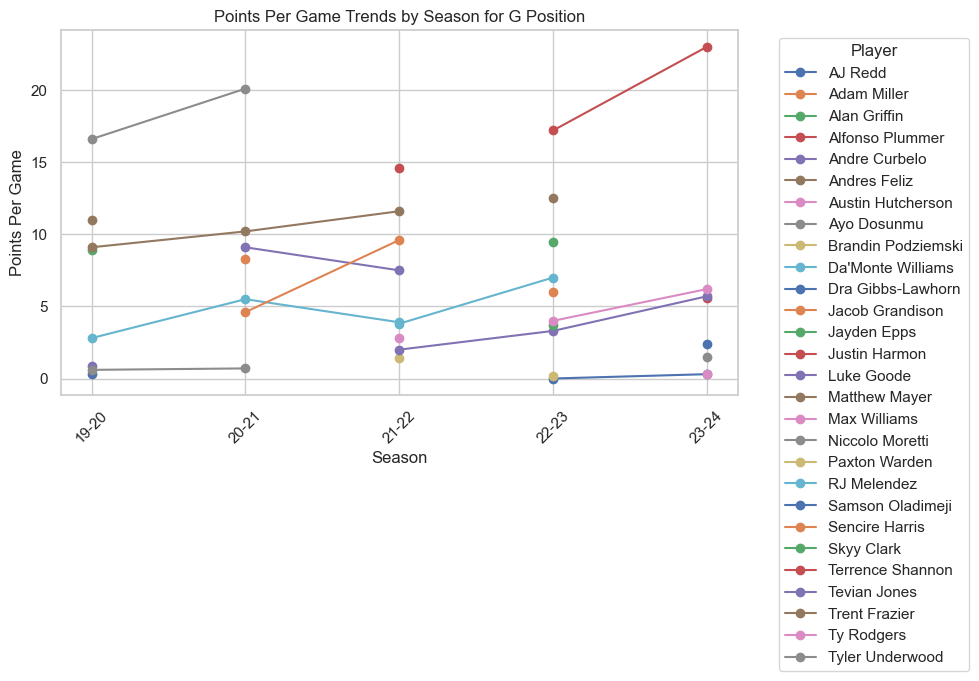

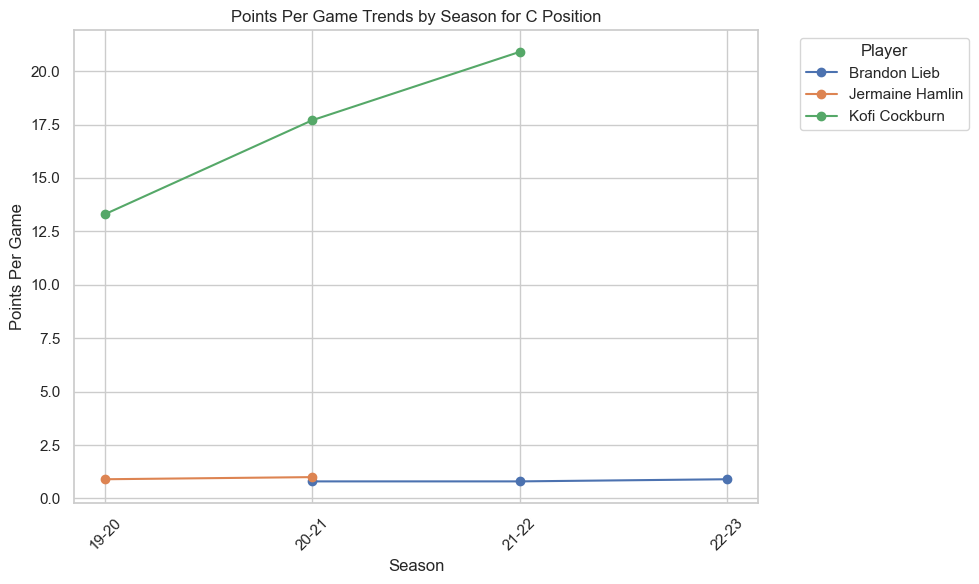

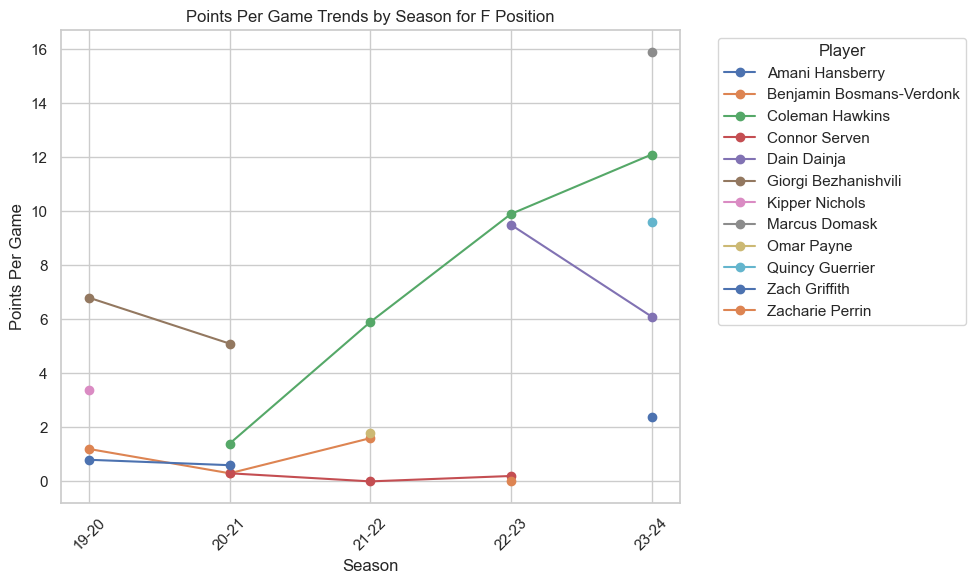

In [ ]:
if 'Pos' in all_rosters.columns and 'PTS' in all_rosters.columns: 
    position = all_rosters['Pos'].unique()
    for pos in position:
        position_data = all_rosters[all_rosters['Pos'] == pos]
        pts_for_pos = position_data.pivot(index = 'Season', columns = 'Player', values = 'PTS')
        plt.figure(figsize = (10,6))
        for player in pts_for_pos.columns: 
            plt.plot(pts_for_pos.index, pts_for_pos[player], marker = 'o', label = player)
        plt.title(f'Points Per Game Trends by Season for {pos} Position')
        plt.xlabel('Season')
        plt.ylabel('Points Per Game')
        plt.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
#Code below makes a linear regression model predicting points based on various metrics 

all_rosters[['Feet', 'Inches']] = all_rosters['Height'].str.split('-', expand= True)
all_rosters['Feet'] = all_rosters['Feet'].astype(int)
all_rosters['Inches'] = all_rosters['Inches'].astype(int)
all_rosters['Height(inches)'] = all_rosters['Feet'] * 12 + all_rosters['Inches']
all_rosters.drop(columns = ['Unnamed: 0']) #converts the height to inches for linear regression model and also cleans it up a little
all_rosters['Predicted PTS'] = all_rosters['PTS']

In [ ]:
x = all_rosters[['PTS', 'AST', 'REB', 'Height(inches)', 'Weight']]
y = all_rosters['Predicted PTS']

drop_na = pd.concat([x, y], axis = 1).dropna()

x_c = drop_na[['PTS', 'AST', 'REB', 'Height(inches)', 'Weight']]
y_c = drop_na['Predicted PTS']

x_train, x_test, y_train, y_test = train_test_split(x_c, y_c, test_size = 0.3, random_state = 42)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
predictions

array([ 3.3,  0.2, 17.2,  0.2,  7. ])

In [ ]:
y_test

53     3.3
55     0.2
44    17.2
56     0.2
49     7.0
Name: Predicted PTS, dtype: float64

In [ ]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("MSE = " + mse.astype(str) + "\n" + "R^2 = " + r2.astype(str))

AttributeError: 'float' object has no attribute 'astype'

In [ ]:
all_rosters

,Player,#,Class,Pos,Height,Weight,Hometown,High School,RSCI Top 100,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,Unnamed: 0,Summary,REB,Feet,Inches,Height(inches),Predicted PTS
0,Ayo Dosunmu,11,SO,G,6-5,200.0,"Chicago, IL",Morgan Park HS,32 (2018),30.0,30.0,33.5,6.5,13.5,0.484,1.0,3.3,0.296,5.6,10.2,0.544,0.520,2.6,3.4,0.755,0.6,3.7,4.3,3.3,0.8,0.2,2.7,1.7,16.6,19-20,NaN,NaN,NaN,6,5,77,16.6
1,Kofi Cockburn,21,FR,C,7-0,285.0,"Kingston, Jamaica",Oak Hill Academy,43 (2019),31.0,31.0,27.4,4.9,9.2,0.532,0.0,0.0,0.000,4.9,9.1,0.534,0.532,3.6,5.3,0.677,3.5,5.3,8.8,0.6,0.5,1.4,1.9,2.6,13.3,19-20,NaN,NaN,NaN,7,0,84,13.3
2,Andres Feliz,10,SR,G,6-2,195.0,"Guachupita, Dominican Republic",West Oaks (FL),NaN,31.0,15.0,26.8,3.9,8.5,0.460,0.5,2.0,0.274,3.4,6.5,0.517,0.492,2.6,3.4,0.769,1.0,4.0,5.0,2.9,0.7,0.0,1.4,1.7,11.0,19-20,NaN,NaN,NaN,6,2,74,11.0
3,Trent Frazier,1,JR,G,6-2,175.0,"Wellington, FL",Wellington High School,NaN,31.0,30.0,30.5,2.8,8.5,0.327,1.6,5.3,0.309,1.1,3.2,0.357,0.424,1.9,2.2,0.853,0.2,2.0,2.2,1.9,0.9,0.0,0.9,2.5,9.1,19-20,NaN,NaN,NaN,6,2,74,9.1
4,Alan Griffin,0,SO,G,6-5,190.0,"Ossining, NY",Archbishop Stepinac HS,NaN,28.0,1.0,18.1,3.1,6.4,0.483,1.7,4.0,0.416,1.4,2.3,0.600,0.615,1.1,1.3,0.861,1.8,2.8,4.5,0.6,0.5,0.2,0.8,1.1,8.9,19-20,NaN,NaN,NaN,6,5,77,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Dra Gibbs-Lawhorn,2,FR,G,6-1,185.0,"Lafayette, IN",McCutcheon (IN); Real Salt Lake Academy (UT); ...,NaN,28.0,0.0,7.1,0.9,2.7,0.342,0.3,1.3,0.222,0.6,1.4,0.450,NaN,0.2,0.3,0.667,0.3,0.6,0.9,0.4,0.1,0.1,0.4,1.0,2.4,23-24,8.0,"2.4 Pts, 0.9 Reb, 0.4 Ast",NaN,6,1,73,2.4
68,Amani Hansberry,35,FR,F,6-8,240.0,"Baltimore, MD",Mount Saint Joseph (MD),58 (2023),19.0,0.0,7.4,1.0,2.2,0.452,0.2,0.7,0.308,0.8,1.5,0.517,NaN,0.2,0.3,0.667,0.6,1.5,2.1,0.3,0.2,0.2,0.1,1.2,2.4,23-24,9.0,"2.4 Pts, 2.1 Reb, 0.3 Ast",NaN,6,8,80,2.4
69,Niccolo Moretti,11,FR,G,6-1,170.0,"Bologna, Italy",DME Academy (FL); NBA Global Academy (Australia),NaN,18.0,0.0,5.9,0.4,0.7,0.667,0.1,0.2,0.667,0.3,0.5,0.667,NaN,0.5,0.8,0.643,0.1,0.7,0.8,0.6,0.1,0.0,0.5,0.4,1.5,23-24,10.0,"1.5 Pts, 0.8 Reb, 0.6 Ast",NaN,6,1,73,1.5
70,AJ Redd,5,SO,G,6-3,170.0,"Chicago, IL",St. Ignatius (IL),NaN,10.0,0.0,2.0,0.1,0.2,0.500,0.0,0.0,NaN,0.1,0.2,0.500,NaN,0.1,0.4,0.250,0.0,0.2,0.2,0.0,0.0,0.0,0.2,0.1,0.3,23-24,11.0,"0.3 Pts, 0.2 Reb, 0.0 Ast",NaN,6,3,75,0.3


In [ ]:
selected_columns = [
    'Player', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', 
    '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 
    'BLK', 'TOV', 'PTS', 'Height(inches)'
]

df_selected_outliers = all_rosters[selected_columns]
df_selected_outliers

,Player,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PTS,Height(inches)
0,Ayo Dosunmu,G,30.0,30.0,33.5,6.5,13.5,0.484,1.0,3.3,0.296,5.6,10.2,0.544,2.6,3.4,0.755,4.3,3.3,0.8,0.2,2.7,16.6,77
1,Kofi Cockburn,C,31.0,31.0,27.4,4.9,9.2,0.532,0.0,0.0,0.000,4.9,9.1,0.534,3.6,5.3,0.677,8.8,0.6,0.5,1.4,1.9,13.3,84
2,Andres Feliz,G,31.0,15.0,26.8,3.9,8.5,0.460,0.5,2.0,0.274,3.4,6.5,0.517,2.6,3.4,0.769,5.0,2.9,0.7,0.0,1.4,11.0,74
3,Trent Frazier,G,31.0,30.0,30.5,2.8,8.5,0.327,1.6,5.3,0.309,1.1,3.2,0.357,1.9,2.2,0.853,2.2,1.9,0.9,0.0,0.9,9.1,74
4,Alan Griffin,G,28.0,1.0,18.1,3.1,6.4,0.483,1.7,4.0,0.416,1.4,2.3,0.600,1.1,1.3,0.861,4.5,0.6,0.5,0.2,0.8,8.9,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Dra Gibbs-Lawhorn,G,28.0,0.0,7.1,0.9,2.7,0.342,0.3,1.3,0.222,0.6,1.4,0.450,0.2,0.3,0.667,0.9,0.4,0.1,0.1,0.4,2.4,73
68,Amani Hansberry,F,19.0,0.0,7.4,1.0,2.2,0.452,0.2,0.7,0.308,0.8,1.5,0.517,0.2,0.3,0.667,2.1,0.3,0.2,0.2,0.1,2.4,80
69,Niccolo Moretti,G,18.0,0.0,5.9,0.4,0.7,0.667,0.1,0.2,0.667,0.3,0.5,0.667,0.5,0.8,0.643,0.8,0.6,0.1,0.0,0.5,1.5,73
70,AJ Redd,G,10.0,0.0,2.0,0.1,0.2,0.500,0.0,0.0,NaN,0.1,0.2,0.500,0.1,0.4,0.250,0.2,0.0,0.0,0.0,0.2,0.3,75


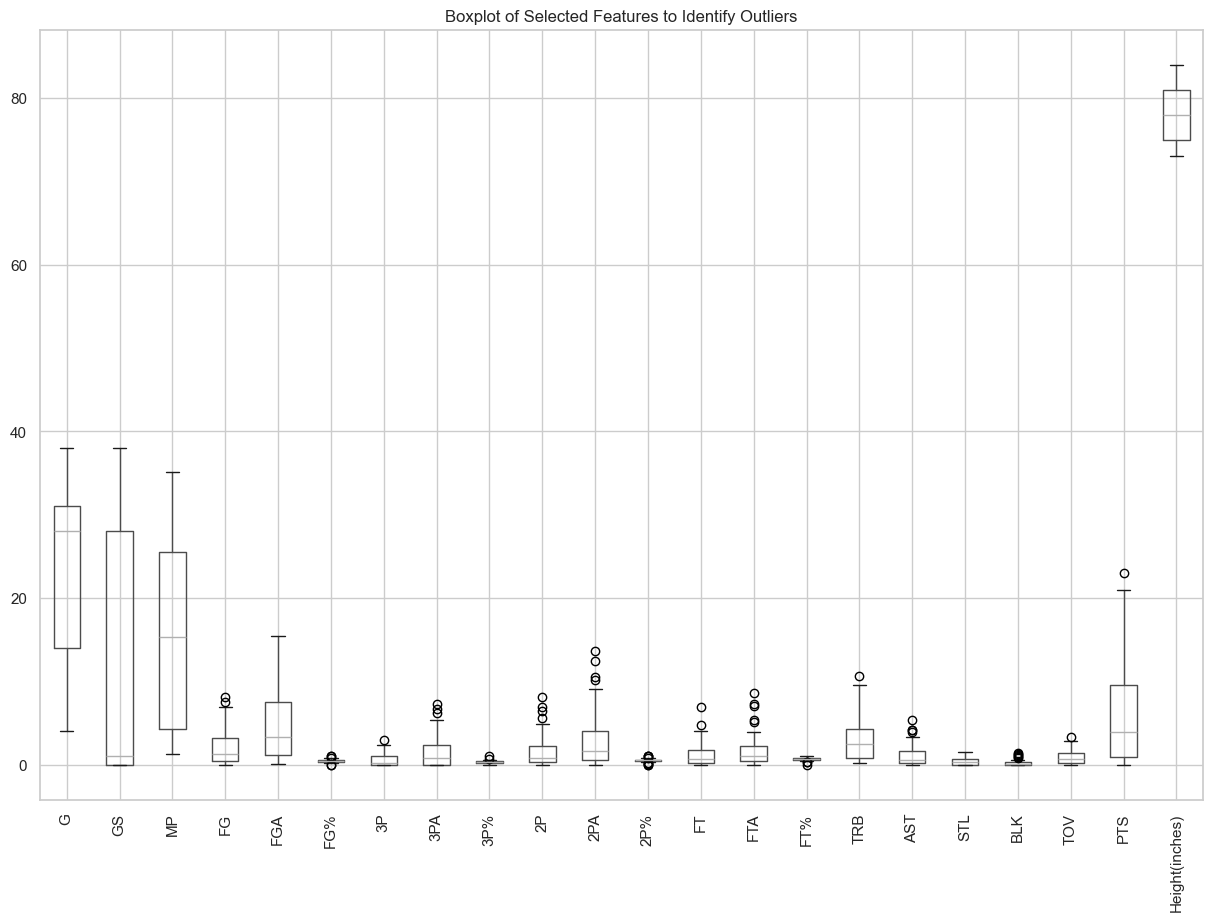

In [ ]:
# looking for outliers within specific features

plt.figure(figsize=(15, 10))
df_selected_outliers.boxplot()
plt.xticks(rotation = 90) 
plt.title("Boxplot of Selected Features to Identify Outliers")
plt.show()

In [ ]:
from scipy.stats import zscore

z_scores = df_selected_outliers.select_dtypes(include=['float64', 'int']).apply(zscore)

outliers = (z_scores.abs() > 3).any(axis=1)
df_outliers = df_selected_outliers[outliers]
df_outliers

,Player,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PTS,Height(inches)
14,Ayo Dosunmu,G,28.0,28.0,35.1,7.5,15.4,0.488,1.1,2.9,0.39,6.4,12.4,0.511,4.0,5.1,0.783,6.3,5.3,1.1,0.2,3.3,20.1,77


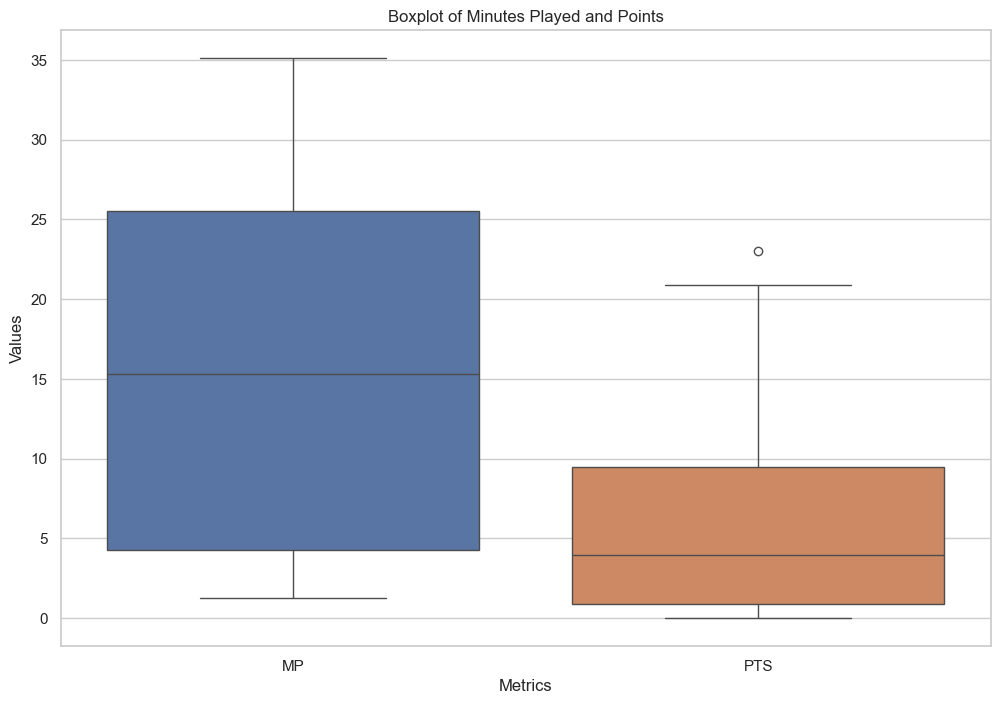

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_selected_outliers[['MP', 'PTS']])
plt.title("Boxplot of Minutes Played and Points")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.show()